In [ ]:
# This cell contains the code from https://github.com/uncbiag/mermaid
# that defines the functions compute_warped_image_multiNC
# which we use for composing maps and identity_map_multiN which we use
# to get an identity map. 
import torch
from torch.autograd import Function
from torch.nn import Module

def scale_map(map,spacing):
    """
    Scales the map to the [-1,1]^d format
    :param map: map in BxCxXxYxZ format
    :param spacing: spacing in XxYxZ format
    :return: returns the scaled map
    """
    sz = map.size()
    map_scaled = torch.zeros_like(map)
    ndim = len(spacing)

    # This is to compensate to get back to the [-1,1] mapping of the following form
    # id[d]*=2./(sz[d]-1)
    # id[d]-=1.

    for d in range(ndim):
        if sz[d+2] >1:
            map_scaled[:, d, ...] = map[:, d, ...] * (2. / (sz[d + 2] - 1.) / spacing[d]) - 1.
        else:
            map_scaled[:, d, ...] = map[:,d,...]

    return map_scaled

class STNFunction_ND_BCXYZ(Module):
    """
   Spatial transform function for 1D, 2D, and 3D. In BCXYZ format (this IS the format used in the current toolbox).
   """

    def __init__(self, spacing, zero_boundary = False,using_bilinear=True,using_01_input=True):
        """
        Constructor
        :param ndim: (int) spatial transformation of the transform
        """
        super(STNFunction_ND_BCXYZ, self).__init__()
        self.spacing = spacing
        self.ndim = len(spacing)
        #zero_boundary = False
        self.zero_boundary = 'zeros' if zero_boundary else 'border'
        self.mode = 'bilinear' if using_bilinear else 'nearest'
        self.using_01_input=using_01_input

    def forward_stn(self, input1, input2, ndim):
        if ndim==1:
            # use 2D interpolation to mimick 1D interpolation
            # now test this for 1D
            phi_rs = input2.reshape(list(input2.size()) + [1])
            input1_rs = input1.reshape(list(input1.size()) + [1])

            phi_rs_size = list(phi_rs.size())
            phi_rs_size[1] = 2

            phi_rs_ordered = torch.zeros(phi_rs_size,dtype=phi_rs.dtype,device=phi_rs.device)
            # keep dimension 1 at zero
            phi_rs_ordered[:, 1, ...] = phi_rs[:, 0, ...]

            output_rs = torch.nn.functional.grid_sample(input1_rs, phi_rs_ordered.permute([0, 2, 3, 1]), mode=self.mode, padding_mode=self.zero_boundary,align_corners=True)
            output = output_rs[:, :, :, 0]

        if ndim==2:
            # todo double check, it seems no transpose is need for 2d, already in height width design
            input2_ordered = torch.zeros_like(input2)
            input2_ordered[:,0,...] = input2[:,1,...]
            input2_ordered[:,1,...] = input2[:,0,...]
            output = torch.nn.functional.grid_sample(input1, input2_ordered.permute([0, 2, 3, 1]), mode=self.mode,
                                          padding_mode=self.zero_boundary,align_corners=True)
        if ndim==3:
            input2_ordered = torch.zeros_like(input2)
            input2_ordered[:, 0, ...] = input2[:, 2, ...]
            input2_ordered[:, 1, ...] = input2[:, 1, ...]
            input2_ordered[:, 2, ...] = input2[:, 0, ...]
            output = torch.nn.functional.grid_sample(input1, input2_ordered.permute([0, 2, 3, 4, 1]), mode=self.mode, padding_mode=self.zero_boundary,align_corners=True)
        return output

    def forward(self, input1, input2):
        """
        Perform the actual spatial transform
        :param input1: image in BCXYZ format
        :param input2: spatial transform in BdimXYZ format
        :return: spatially transformed image in BCXYZ format
        """

        assert(len(self.spacing)+2==len(input2.size()))
        if self.using_01_input:
            output = self.forward_stn(input1, scale_map(input2,self.spacing), self.ndim)
        else:
            output = self.forward_stn(input1, input2, self.ndim)
        # print(STNVal(output, ini=-1).sum())
        return output

class STN_ND_BCXYZ(Module):
    """
    Spatial transform code for nD spatial transoforms. Uses the BCXYZ image format.
    """
    def __init__(self, spacing, zero_boundary=False,use_bilinear=True,use_01_input=True,use_compile_version=False):
        super(STN_ND_BCXYZ, self).__init__()
        self.spacing = spacing
        """spatial dimension"""
        if use_compile_version:
            if use_bilinear:
                self.f = STNFunction_ND_BCXYZ_Compile(self.spacing,zero_boundary)
            else:
                self.f = partial(get_nn_interpolation,spacing = self.spacing)
        else:
            self.f = STNFunction_ND_BCXYZ( self.spacing,zero_boundary= zero_boundary,using_bilinear= use_bilinear,using_01_input = use_01_input)

        """spatial transform function"""
    def forward(self, input1, input2):
        """
       Simply returns the transformed input
       :param input1: image in BCXYZ format 
       :param input2: map in BdimXYZ format
       :return: returns the transformed image
       """
        return self.f(input1, input2)

def compute_warped_image_multiNC(I0, phi, spacing, spline_order, zero_boundary=False, use_01_input=True):
    """Warps image.
    :param I0: image to warp, image size BxCxXxYxZ
    :param phi: map for the warping, size BxdimxXxYxZ
    :param spacing: image spacing [dx,dy,dz]
    :return: returns the warped image of size BxCxXxYxZ
    """

    dim = I0.dim()-2
    if dim == 1:
        return _compute_warped_image_multiNC_1d(I0, phi, spacing, spline_order,zero_boundary,use_01_input=use_01_input)
    elif dim == 2:
        return _compute_warped_image_multiNC_2d(I0, phi, spacing, spline_order,zero_boundary,use_01_input=use_01_input)
    elif dim == 3:
        return _compute_warped_image_multiNC_3d(I0, phi, spacing, spline_order,zero_boundary,use_01_input=use_01_input)
    else:
        raise ValueError('Images can only be warped in dimensions 1 to 3')

def _compute_warped_image_multiNC_2d(I0, phi, spacing, spline_order,zero_boundary=False,use_01_input=True):

    if spline_order not in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
        raise ValueError('Currently only orders 0 to 9 are supported')

    if spline_order == 0:
        stn = STN_ND_BCXYZ(spacing,
                           zero_boundary,
                           use_bilinear=False,
                           use_01_input=use_01_input)
    elif spline_order == 1:
        stn = STN_ND_BCXYZ(spacing,
                           zero_boundary,
                           use_bilinear=True,
                           use_01_input=use_01_input)
    else:
        stn = SplineInterpolation_ND_BCXYZ(spacing,
                                           spline_order)

    I1_warped = stn(I0, phi)

    return I1_warped
def identity_map_multiN(sz,spacing,dtype='float32'):
    """
    Create an identity map
    :param sz: size of an image in BxCxXxYxZ format
    :param spacing: list with spacing information [sx,sy,sz]
    :param dtype: numpy data-type ('float32', 'float64', ...)
    :return: returns the identity map
    """
    dim = len(sz)-2
    nrOfI = int(sz[0])

    if dim == 1:
        id = np.zeros([nrOfI,1,sz[2]],dtype=dtype)
    elif dim == 2:
        id = np.zeros([nrOfI,2,sz[2],sz[3]],dtype=dtype)
    elif dim == 3:
        id = np.zeros([nrOfI,3,sz[2],sz[3],sz[4]],dtype=dtype)
    else:
        raise ValueError('Only dimensions 1-3 are currently supported for the identity map')

    for n in range(nrOfI):
        id[n,...] = identity_map(sz[2::],spacing,dtype=dtype)

    return id
def identity_map(sz,spacing,dtype='float32'):
    """
    Returns an identity map.
    :param sz: just the spatial dimensions, i.e., XxYxZ
    :param spacing: list with spacing information [sx,sy,sz]
    :param dtype: numpy data-type ('float32', 'float64', ...)
    :return: returns the identity map of dimension dimxXxYxZ
    """
    dim = len(sz)
    if dim==1:
        id = np.mgrid[0:sz[0]]
    elif dim==2:
        id = np.mgrid[0:sz[0],0:sz[1]]
    elif dim==3:
        id = np.mgrid[0:sz[0],0:sz[1],0:sz[2]]
    else:
        raise ValueError('Only dimensions 1-3 are currently supported for the identity map')

    # now get it into range [0,(sz-1)*spacing]^d
    id = np.array( id.astype(dtype) )
    if dim==1:
        id = id.reshape(1,sz[0]) # add a dummy first index

    for d in range(dim):
        id[d]*=spacing[d]

        #id[d]*=2./(sz[d]-1)
        #id[d]-=1.

    # and now store it in a dim+1 array
    if dim==1:
        idnp = np.zeros([1, sz[0]], dtype=dtype)
        idnp[0,:] = id[0]
    elif dim==2:
        idnp = np.zeros([2, sz[0], sz[1]], dtype=dtype)
        idnp[0,:, :] = id[0]
        idnp[1,:, :] = id[1]
    elif dim==3:
        idnp = np.zeros([3,sz[0], sz[1], sz[2]], dtype=dtype)
        idnp[0,:, :, :] = id[0]
        idnp[1,:, :, :] = id[1]
        idnp[2,:, :, :] = id[2]
    else:
        raise ValueError('Only dimensions 1-3 are currently supported for the identity map')

    return idnp


In [1]:
import sys
import os
import glob
import itk
import random
import mermaid
brain_paths = glob.glob("/playpen-raid/zhenlinx/Data/OAI/*/*/*/*/image_normalized.nii.gz")
import mermaid.visualize_registration_results
import matplotlib.pyplot as plt
import numpy as np
print(len(brain_paths))

cartilage1_paths = glob.glob("/playpen-raid/zhenlinx/Data/OAI/*/*/*/*/*/cartilage_FC_TC_mask.nii.gz")
print(len(cartilage1_paths))

Will read from /playpen-raid1/tgreer/anaconda3/envs/mermaid4/lib/python3.7/site-packages/mermaid/../mermaid_settings/compute_settings.json
Will read from /playpen-raid1/tgreer/anaconda3/envs/mermaid4/lib/python3.7/site-packages/mermaid/../mermaid_settings/compute_settings_comments.json
Will read from /playpen-raid1/tgreer/anaconda3/envs/mermaid4/lib/python3.7/site-packages/mermaid/../mermaid_settings/baseconf_settings.json
Will read from /playpen-raid1/tgreer/anaconda3/envs/mermaid4/lib/python3.7/site-packages/mermaid/../mermaid_settings/baseconf_settings_comments.json
Will read from /playpen-raid1/tgreer/anaconda3/envs/mermaid4/lib/python3.7/site-packages/mermaid/../mermaid_settings/algconf_settings.json
Will read from /playpen-raid1/tgreer/anaconda3/envs/mermaid4/lib/python3.7/site-packages/mermaid/../mermaid_settings/algconf_settings_comments.json
Will read from /playpen-raid1/tgreer/anaconda3/envs/mermaid4/lib/python3.7/site-packages/mermaid/../mermaid_settings/democonf_settings.js

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
import sys
import os
import matplotlib.pyplot as plt
import mermaid.module_parameters as pars
import mermaid.model_factory as py_mf
import mermaid.utils as py_utils
import mermaid.similarity_measure_factory as smf
from mermaid.data_wrapper import AdaptVal
import mermaid.image_sampling as py_is
import mermaid.example_generation as eg

import numpy as np


In [3]:
cartilage = [torch.tensor([itk.GetArrayFromImage(itk.imread(b))]) for b in cartilage1_paths]
print("cartilage done")
brains = [torch.tensor([itk.GetArrayFromImage(itk.imread(b))]) for b in brain_paths]
#brains = [b for b in brains]

#brains = [b / np.max(b) for b in brains]

KeyboardInterrupt: 

In [ ]:
for idx in range(len(brains)):
    if "RIGHT" in brain_paths[idx]:
        brains[idx] = torch.flip(brains[idx], [1])

In [19]:
for idx in range(len(cartilage)):
    if "RIGHT" in cartilage1_paths[idx]:
        cartilage[idx] = torch.flip(torch.tensor(cartilage[idx]), [1])

/playpen-raid1/tgreer/anaconda3/envs/mermaid4/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


In [1]:
import pickle
with open("/playpen/tgreer/mediumknees", "rb") as f:
    medbrains = pickle.load(f)
for idx in range(len(medbrains)):
    if "RIGHT" in brain_paths[idx]:
        medbrains[idx] = torch.flip(medbrains[idx], [1])

NameError: name 'brain_paths' is not defined

In [3]:
import pickle
with open("/playpen/tgreer/knees4", "rb") as f:
    brains = pickle.load(f)

In [4]:
smolbrains = [F.avg_pool3d(b, 2) for b in brains]

In [6]:
medbrains = [F.avg_pool3d(torch.tensor([b]), 4) for b in brains]

NameError: name 'brains' is not defined

In [5]:
import matplotlib.pyplot as plt

In [5]:
BATCH_SIZE = 4

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
class RegisNet(nn.Module):
    def __init__(self):
        super(RegisNet, self).__init__()
        self.conv1 = nn.Conv2d(2, 10, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(12, 10, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(22, 10, kernel_size=5, padding=2)
        self.conv4 = nn.Conv2d(32, 10, kernel_size=5, padding=2)
        self.conv5 = nn.Conv2d(42, 10, kernel_size=5, padding=2)
        self.conv6 = nn.Conv2d(52, 2, kernel_size=5, padding=2)

    def forward(self, x, y):
        x= torch.cat([x, y], 1)
        
        x = torch.cat([x, F.relu(self.conv1(x))], 1)
        x = torch.cat([x, F.relu(self.conv2(x))], 1)
        x = torch.cat([x, F.relu(self.conv3(x))], 1)
        x = torch.cat([x, F.relu(self.conv4(x))], 1)
        x = torch.cat([x, F.relu(self.conv5(x))], 1)
        
        return self.conv6(x)

class UNet(nn.Module):
    def __init__(self, num_layers, channels):
        super(UNet, self).__init__()
        self.num_layers = num_layers
        down_channels = channels[0]
        up_channels_out = channels[1]
        up_channels_in = channels[2]
        self.downConvs = nn.ModuleList([])
        self.upConvs = nn.ModuleList([])
        self.batchNorms = nn.ModuleList(
            [nn.BatchNorm3d(num_features = up_channels_out[depth])
             for depth in reversed(range(self.num_layers))])
        for depth in range(self.num_layers):
            self.downConvs.append( 
                nn.Conv3d(
                    down_channels[depth], 
                    down_channels[depth + 1],
                    kernel_size=3,
                    padding=1,
                    stride=2
                )
            )
        for depth in reversed(range(self.num_layers)):
            self.upConvs.append(
                nn.ConvTranspose3d(
                    up_channels_in[depth], 
                    up_channels_out[depth],
                    kernel_size=4,
                    padding=1,
                    stride=2
                )
            )
        self.lastConv = nn.Conv3d(
            18, 3, kernel_size=3, padding=1)
        torch.nn.init.zeros_(self.lastConv.weight)
        self.backwardsDepth = tuple(reversed(range(self.num_layers)))
     
    def forward(self, x, y):
        x = torch.cat([x, y], 1)
        skips = []
        for downConv in self.downConvs:
            skips.append(x)
            x = F.relu(downConv(x))
        for depth, upconv, batchnorm in zip(self.backwardsDepth, self.upConvs, self.batchNorms):
            x = F.relu(upconv(x))
            x = batchnorm(x)
            
            x = x[:, :, :skips[depth].size()[2], :skips[depth].size()[3], 
                 :skips[depth].size()[4]]
            x = torch.cat([x, skips[depth]], 1)
            
        x = self.lastConv(x)
        return x / 10
    
def shortUNet():
    return UNet(4, [
        [2, 16, 32, 64, 256],
        [16, 32, 64, 128],
        [48, 96, 192, 256]
    ])

def tallUNet():
    return UNet(7, [
        [2, 8, 16, 32, 256, 512, 1024, 1024],
        [8, 16, 32, 128, 256, 512, 1024],
        [8 + 16, 16 + 32, 32 + 128, 512, 1024, 2048, 1024]
    ])

class MermaidNet(nn.Module):
    def __init__(self, device=None):
        super(MermaidNet, self).__init__()       
        
        self.sz = np.array([BATCH_SIZE, 1, 40 * 2, 96 * 2, 96 * 2])
        self.spacing = 1./(self.sz[2::]-1) 
        
        _id = py_utils.identity_map_multiN(self.sz, self.spacing)
        self.register_buffer("identityMap", torch.from_numpy(_id))
            
        self.regis_net = shortUNet()
        
    def adjust_batch_size(self, BATCH_SIZE):
        self.sz = np.array([BATCH_SIZE, 1, 40 * 2, 96 * 2, 96 * 2])
        self.spacing = 1./(self.sz[2::]-1) 
        
        _id = py_utils.identity_map_multiN(self.sz, self.spacing)
        self.register_buffer("identityMap", torch.from_numpy(_id))
        
        
    def forward(self, moving_image, fixed_image):
        

        phi1 = self.regis_net(moving_image, fixed_image) + self.identityMap
        
        phiinv = self.regis_net(fixed_image, moving_image) + self.identityMap
        
        warped_moving_image = py_utils.compute_warped_image_multiNC(
            moving_image, phi1, self.spacing, 1)
        
        warped_fixed_image = py_utils.compute_warped_image_multiNC(
            fixed_image, phiinv, self.spacing, 1)
        
        fake_ident = py_utils.compute_warped_image_multiNC(
            phiinv - self.identityMap, phi1, self.spacing, 1) + phi1
        ll = 160
        regularization_loss = ll * torch.mean(
            (self.identityMap - fake_ident)**2)
        distortion_magnitude = ll * torch.mean(
            (self.identityMap - phi1)**2
        )
        similarity_loss = (
            torch.mean((warped_moving_image - fixed_image)**2) + 
            torch.mean((warped_fixed_image - moving_image)**2)
        )
        #print(regularization_loss.detach().cpu().item(), similarity_loss.detach().cpu().item(), 
        #     self.distortion_magnitude.detach().cpu().item())
        
        all_loss = regularization_loss + similarity_loss
        return all_loss, regularization_loss, similarity_loss, distortion_magnitude

net = MermaidNet()
0

0

In [6]:
net_par = net.cuda()

In [7]:

net_par = torch.nn.DataParallel(net).cuda()

In [8]:
optimizer = torch.optim.Adam(net_par.parameters(), lr=.00005)


In [9]:
net_par.train()
0

0

In [ ]:
def make_batch():
    image = torch.cat([random.choice(smolbrains) for _ in range(4* BATCH_SIZE)])
    image = image.reshape(4 * BATCH_SIZE, 1, 40 * 2, 96 * 2, 96 * 2)
    image = image.cuda()
    return image

import torch.autograd.profiler as profiler
for _ in range(100000):
    optimizer.zero_grad()
    for subbatch in range(8):
        moving_image = make_batch()
        fixed_image = make_batch()
        loss, a, b, c = net_par(moving_image, fixed_image)
        loss = torch.mean(loss)
        loss.backward()
    
    print([torch.mean(l.detach().cpu()).item() for l in (a, b, c)])
    
    optimizer.step()

        


/playpen-raid1/tgreer/anaconda3/envs/mermaid4/lib/python3.7/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/playpen-raid1/tgreer/anaconda3/envs/mermaid4/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


[0.008816758170723915, 0.05430704355239868, 0.0022041895426809788]
[0.00858638621866703, 0.05474217236042023, 0.002147629391402006]
[0.008419167250394821, 0.05828621983528137, 0.0021086514461785555]
[0.008156580850481987, 0.05413970351219177, 0.0020451771561056376]
[0.0078534334897995, 0.057571008801460266, 0.001971391960978508]
[0.007612815126776695, 0.049758851528167725, 0.0019141038646921515]
[0.007390706799924374, 0.0567268505692482, 0.0018624956719577312]
[0.007131925318390131, 0.05910677835345268, 0.001802212093025446]
[0.0068977754563093185, 0.06097151339054108, 0.0017492142505943775]
[0.006687937304377556, 0.05500227212905884, 0.001702403067611158]
[0.0064580123871564865, 0.055633947253227234, 0.0016508675180375576]
[0.0063123879954218864, 0.05073665827512741, 0.0016210880130529404]
[0.00610280130058527, 0.05185278505086899, 0.001576827373355627]
[0.005940360017120838, 0.05172186344861984, 0.0015449384227395058]
[0.005637577269226313, 0.05770266056060791, 0.001479742000810802]


[0.0018129530362784863, 0.048213884234428406, 0.014682772569358349]
[0.0016763880848884583, 0.0455293282866478, 0.013008743524551392]
[0.0017841467633843422, 0.04523112624883652, 0.01374092511832714]
[0.0017793775768950582, 0.044575415551662445, 0.014937900006771088]
[0.0016035991720855236, 0.04843664914369583, 0.016780246049165726]
[0.0018557667499408126, 0.04684176295995712, 0.014843886718153954]
[0.0018024919554591179, 0.04507540166378021, 0.015195392072200775]
[0.001823332393541932, 0.04351501166820526, 0.015088533982634544]
[0.0020602259319275618, 0.047019779682159424, 0.016729991883039474]
[0.001797933247871697, 0.05098278820514679, 0.017429424449801445]
[0.0017977524548768997, 0.04397585615515709, 0.015680812299251556]
[0.0019003433408215642, 0.04387468844652176, 0.015161782503128052]
[0.0016630314057692885, 0.04450774937868118, 0.015305692330002785]
[0.0019507501274347305, 0.044837795197963715, 0.0171815212816]
[0.0017798596527427435, 0.04461422190070152, 0.016746722161769867]


[0.0017661810852587223, 0.0455317422747612, 0.02820100635290146]
[0.0017755619483068585, 0.040177248418331146, 0.027108144015073776]
[0.002074422547593713, 0.042054109275341034, 0.030633946880698204]
[0.002068836474791169, 0.04109761863946915, 0.028334178030490875]
[0.001977918203920126, 0.04122093692421913, 0.02963533252477646]
[0.002200210699811578, 0.03989831358194351, 0.0301378071308136]
[0.0019737882539629936, 0.042273856699466705, 0.03178033232688904]
[0.001968617783859372, 0.042210258543491364, 0.02965082786977291]
[0.001956006046384573, 0.041152290999889374, 0.029775097966194153]
[0.002208419842645526, 0.039458226412534714, 0.026785891503095627]
[0.0017657004063948989, 0.04226459562778473, 0.031744517385959625]
[0.0020403291564434767, 0.0450315997004509, 0.028957024216651917]
[0.0019892638083547354, 0.04278911277651787, 0.030595850199460983]
[0.002015930600464344, 0.043553777039051056, 0.02898913249373436]
[0.002051220741122961, 0.04265706613659859, 0.029683668166399002]
[0.002

[0.0026293774135410786, 0.03891628235578537, 0.036300551146268845]
[0.002449724590405822, 0.03608723729848862, 0.03568778932094574]
[0.0027688511181622744, 0.03935258463025093, 0.03612811118364334]
[0.002450072206556797, 0.037185728549957275, 0.038548387587070465]
[0.0024188868701457977, 0.04169559106230736, 0.03753833472728729]
[0.0024369070306420326, 0.038995254784822464, 0.03743043541908264]
[0.0024558445438742638, 0.042758919298648834, 0.0416768379509449]
[0.002586586633697152, 0.03984024375677109, 0.0398784764111042]
[0.0026632847730070353, 0.03853477165102959, 0.040535248816013336]
[0.0027477324474602938, 0.04040824994444847, 0.03873588144779205]
[0.002395621035248041, 0.04263542965054512, 0.04026570916175842]
[0.0023906733840703964, 0.03857629746198654, 0.03598687797784805]
[0.0024567749351263046, 0.034805987030267715, 0.03551911190152168]
[0.0026497505605220795, 0.0395192950963974, 0.037407275289297104]
[0.002432881621643901, 0.03839373588562012, 0.04011954739689827]
[0.0025015

[0.0027687763795256615, 0.03729769587516785, 0.04115289822220802]
[0.0027656301390379667, 0.038664497435092926, 0.0432685948908329]
[0.0025781532749533653, 0.03671807050704956, 0.04609743133187294]
[0.00278692739084363, 0.036516763269901276, 0.04434448480606079]
[0.002569032134488225, 0.03596381098031998, 0.045653536915779114]
[0.002947166096419096, 0.037463895976543427, 0.043801501393318176]
[0.0030453752260655165, 0.039206720888614655, 0.04535680264234543]
[0.0025505058001726866, 0.03533228486776352, 0.04501086100935936]
[0.002540722256526351, 0.034508395940065384, 0.04362817853689194]
[0.00246417336165905, 0.035326920449733734, 0.04500453174114227]
[0.002863246016204357, 0.03875860571861267, 0.04705413803458214]
[0.002724295947700739, 0.039606571197509766, 0.04856835678219795]
[0.0026900265365839005, 0.03807599097490311, 0.04652530327439308]
[0.0028338655829429626, 0.03755222260951996, 0.0475093238055706]
[0.0027981605380773544, 0.04013502225279808, 0.049388375133275986]
[0.00267457

[0.0028568622656166553, 0.0360555574297905, 0.048182688653469086]
[0.0027695740573108196, 0.03567318245768547, 0.04785382002592087]
[0.0025550336576998234, 0.03737260773777962, 0.054865188896656036]
[0.0026560674887150526, 0.036409854888916016, 0.05139106512069702]
[0.002671731635928154, 0.03291192650794983, 0.0496300533413887]
[0.002827963326126337, 0.036893244832754135, 0.04793746769428253]
[0.002721458673477173, 0.03359811007976532, 0.047933802008628845]
[0.002550204750150442, 0.03340554237365723, 0.04739398881793022]
[0.0026202567387372255, 0.035666096955537796, 0.05198419839143753]
[0.0027212235145270824, 0.03616734594106674, 0.048806846141815186]
[0.0026504991110414267, 0.03888781741261482, 0.05360645800828934]
[0.002725807949900627, 0.034712642431259155, 0.04917367920279503]
[0.0025030765682458878, 0.03375479578971863, 0.050969529896974564]
[0.00251618679612875, 0.03257065638899803, 0.049253255128860474]
[0.0026328235398977995, 0.03515365719795227, 0.04983435571193695]
[0.002528

[0.002806894015520811, 0.03721465542912483, 0.05649606138467789]
[0.0028466249350458384, 0.03569013997912407, 0.05619809776544571]
[0.002798086032271385, 0.03504791483283043, 0.05163547396659851]
[0.0025359811261296272, 0.035110510885715485, 0.05359845235943794]
[0.0023652715608477592, 0.03335016220808029, 0.05483945831656456]
[0.0026400741189718246, 0.03422883152961731, 0.055102162063121796]
[0.002621756400913, 0.03628264367580414, 0.057429488748311996]
[0.002561029512435198, 0.03522918373346329, 0.05808423459529877]
[0.0025251805782318115, 0.03320315480232239, 0.05179997906088829]
[0.0022941515780985355, 0.03251440450549126, 0.057569991797208786]
[0.002677635522559285, 0.03677796572446823, 0.05692391097545624]
[0.00247394572943449, 0.03541368991136551, 0.053400807082653046]
[0.00284638162702322, 0.03553337603807449, 0.05148310214281082]
[0.00265039992518723, 0.03762730211019516, 0.0574830062687397]
[0.0025865258648991585, 0.03172391280531883, 0.05368858575820923]
[0.00273825158365070

[0.0024369345046579838, 0.034057408571243286, 0.057576779276132584]
[0.002483298536390066, 0.033965036273002625, 0.056552350521087646]
[0.002399349119514227, 0.034042198210954666, 0.05952242761850357]
[0.002552984282374382, 0.03366364911198616, 0.059479448944330215]
[0.002674531890079379, 0.03494969755411148, 0.057801030576229095]
[0.0027702453080564737, 0.032508742064237595, 0.051554881036281586]
[0.002783676842227578, 0.03367937356233597, 0.05890330672264099]
[0.002829277887940407, 0.0321524478495121, 0.05570502206683159]
[0.002684828592464328, 0.03583839163184166, 0.06068243831396103]
[0.002762595424428582, 0.03568223863840103, 0.062040895223617554]
[0.0028208144940435886, 0.039429809898138046, 0.06028471142053604]
[0.0027628906536847353, 0.033505361527204514, 0.054654497653245926]
[0.0025163362734019756, 0.03284100815653801, 0.0532352514564991]
[0.002564042806625366, 0.032488685101270676, 0.056652918457984924]
[0.0028846352361142635, 0.03231402114033699, 0.05090668797492981]
[0.002

[0.00262276129797101, 0.03220043331384659, 0.06004773825407028]
[0.002663218881934881, 0.0336015559732914, 0.05656040832400322]
[0.0026839275378733873, 0.03817453235387802, 0.061578840017318726]
[0.0026859664358198643, 0.03316010534763336, 0.060050517320632935]
[0.002621075138449669, 0.03238680958747864, 0.0605916865170002]
[0.002613252028822899, 0.02774709463119507, 0.05210172012448311]
[0.0027919760905206203, 0.0336868092417717, 0.05792045593261719]
[0.002681662328541279, 0.03336603567004204, 0.05767286196351051]
[0.002599033061414957, 0.03390639275312424, 0.059111133217811584]
[0.0025768557097762823, 0.03159424290060997, 0.05476761609315872]
[0.0029008095152676105, 0.03506361320614815, 0.05964286997914314]
[0.0026701069436967373, 0.03317129611968994, 0.059674013406038284]
[0.00267551327124238, 0.034606337547302246, 0.06316271424293518]
[0.002762614283710718, 0.032998234033584595, 0.05728079378604889]
[0.002454115077853203, 0.032050721347332, 0.05849740281701088]
[0.00254789600148797

[0.0029015876352787018, 0.03288614749908447, 0.05897277593612671]
[0.002586551010608673, 0.03527402877807617, 0.06228438764810562]
[0.0025986204855144024, 0.032347746193408966, 0.06029129773378372]
[0.002836198080331087, 0.03272799402475357, 0.056413762271404266]
[0.0027385561261326075, 0.03004179149866104, 0.05373764410614967]
[0.0025580297224223614, 0.0321783572435379, 0.06051885709166527]
[0.0026058347430080175, 0.032738134264945984, 0.05570554733276367]
[0.002420105505734682, 0.03086746670305729, 0.0558166541159153]
[0.002927064662799239, 0.03444545343518257, 0.05892174690961838]
[0.002553163096308708, 0.036292266100645065, 0.0642106682062149]
[0.0024845246225595474, 0.03038991242647171, 0.056756485253572464]
[0.002707982901483774, 0.037886686623096466, 0.07010155916213989]
[0.0025974330492317677, 0.032438576221466064, 0.06091473996639252]
[0.002669515088200569, 0.03338787332177162, 0.06691241264343262]
[0.002650478621944785, 0.031743425875902176, 0.05802072212100029]
[0.0027690459

[0.0026555622462183237, 0.03319234028458595, 0.06401968002319336]
[0.002669288543984294, 0.031238708645105362, 0.0612025260925293]
[0.002818961162120104, 0.03414778411388397, 0.05964561924338341]
[0.0027468241751194, 0.03351207450032234, 0.06571392714977264]
[0.0024614492431282997, 0.030293500050902367, 0.05975069850683212]
[0.0025375219993293285, 0.030522849410772324, 0.05930730700492859]
[0.0025517670437693596, 0.030982794240117073, 0.059405989944934845]
[0.002575658494606614, 0.03446781635284424, 0.07059578597545624]
[0.0027828554157167673, 0.03275194764137268, 0.06780912727117538]
[0.002770403167232871, 0.034836381673812866, 0.06541904807090759]
[0.0025832843966782093, 0.02961980178952217, 0.056781742721796036]
[0.0027738427743315697, 0.032064907252788544, 0.060922831296920776]
[0.0025912425480782986, 0.03529101237654686, 0.0682363212108612]
[0.0026748613454401493, 0.031626928597688675, 0.05783195421099663]
[0.0027145727071911097, 0.033028554171323776, 0.0594605877995491]
[0.002609

[0.002557863015681505, 0.029337624087929726, 0.057932768017053604]
[0.0027902466244995594, 0.033962998539209366, 0.06671568751335144]
[0.002732637571170926, 0.0321342833340168, 0.06455947458744049]
[0.0026916475035250187, 0.03200363367795944, 0.06239648908376694]
[0.0027585614006966352, 0.03392389789223671, 0.0674278736114502]
[0.0025002318434417248, 0.030082736164331436, 0.061736032366752625]
[0.002794327214360237, 0.032073117792606354, 0.06181040406227112]
[0.0025474056601524353, 0.030396590009331703, 0.0644240751862526]
[0.0026865017134696245, 0.031388986855745316, 0.0665123239159584]
[0.002732126973569393, 0.033205900341272354, 0.06479612737894058]
[0.0025193358305841684, 0.0322408601641655, 0.06758169084787369]
[0.002556790132075548, 0.03289523348212242, 0.06250430643558502]
[0.0024730167351663113, 0.032170336693525314, 0.06788407266139984]
[0.0027238386683166027, 0.03263538330793381, 0.06362540274858475]
[0.0027692324947565794, 0.03118351474404335, 0.06453538686037064]
[0.0029929

[0.002640661085024476, 0.03376121073961258, 0.06417158991098404]
[0.002648432506248355, 0.03155064210295677, 0.06199617311358452]
[0.002476808615028858, 0.031125161796808243, 0.06280424445867538]
[0.0025966609828174114, 0.030695701017975807, 0.06427940726280212]
[0.002701548859477043, 0.032975971698760986, 0.06913566589355469]
[0.0027628429234027863, 0.03436802700161934, 0.06672627478837967]
[0.0026096259243786335, 0.03307971730828285, 0.0732814371585846]
[0.0026587452739477158, 0.03189857304096222, 0.05969972535967827]
[0.002603714121505618, 0.03258891403675079, 0.07040724903345108]
[0.002626997185871005, 0.03134555369615555, 0.06809454411268234]
[0.0025432587135583162, 0.030968382954597473, 0.06684581935405731]
[0.002544144168496132, 0.03053753450512886, 0.06896162778139114]
[0.0025534103624522686, 0.028480298817157745, 0.056607626378536224]
[0.00256005278788507, 0.03023618832230568, 0.06032659113407135]
[0.0026692626997828484, 0.032100677490234375, 0.058382388204336166]
[0.002419104

[0.0026280370075255632, 0.03168482333421707, 0.06565258651971817]
[0.0025560802314430475, 0.03296384960412979, 0.07158329337835312]
[0.002904856577515602, 0.03287660703063011, 0.06420192867517471]
[0.0028963685035705566, 0.03297608345746994, 0.06337326765060425]
[0.002406009938567877, 0.03061899170279503, 0.07226460427045822]
[0.002693320158869028, 0.029500054195523262, 0.06046012043952942]
[0.002737998263910413, 0.033700138330459595, 0.07065033167600632]
[0.0025476000737398863, 0.030907055363059044, 0.06360793113708496]
[0.0026626160833984613, 0.03219000622630119, 0.06744001060724258]
[0.002647966146469116, 0.031046926975250244, 0.06462446600198746]
[0.002679340075701475, 0.03311919420957565, 0.0716806948184967]
[0.002615842502564192, 0.033205121755599976, 0.0687691941857338]
[0.00273652421310544, 0.03261330723762512, 0.06665005534887314]
[0.002610837109386921, 0.03251760080456734, 0.06078547611832619]
[0.002653390634804964, 0.0327066034078598, 0.07005693018436432]
[0.0025685066357254

[0.002476485213264823, 0.02927909791469574, 0.060606103390455246]
[0.0027393281925469637, 0.03230975568294525, 0.06396868079900742]
[0.002494532149285078, 0.030739562585949898, 0.06310516595840454]
[0.002738320967182517, 0.032643288373947144, 0.06769062578678131]
[0.0024456512182950974, 0.02944708801805973, 0.06057000532746315]
[0.0026418548077344894, 0.031832367181777954, 0.06208396330475807]
[0.002629004418849945, 0.032230399549007416, 0.07097908109426498]
[0.0026699465233832598, 0.03340689837932587, 0.07443167269229889]
[0.002486816607415676, 0.028660548850893974, 0.0625285804271698]
[0.002386483596637845, 0.029069809243083, 0.06936046481132507]
[0.002492805477231741, 0.029282577335834503, 0.06356611102819443]
[0.0025420624297112226, 0.03012908808887005, 0.06971213221549988]
[0.0025523651856929064, 0.03167913109064102, 0.06373992562294006]
[0.002473084721714258, 0.029421186074614525, 0.06449638307094574]
[0.0025581629015505314, 0.029822375625371933, 0.06722389906644821]
[0.002367926

[0.0027612438425421715, 0.0302576944231987, 0.06216990202665329]
[0.002529720775783062, 0.03171015903353691, 0.07093221694231033]
[0.0025127751287072897, 0.03207462280988693, 0.07306858897209167]
[0.002618966391310096, 0.031009498983621597, 0.0650520846247673]
[0.0024953691754490137, 0.02983471192419529, 0.06822162121534348]
[0.002557536121457815, 0.030979858711361885, 0.06964918971061707]
[0.002577768871560693, 0.030944498255848885, 0.07164289802312851]
[0.002534903585910797, 0.030321627855300903, 0.07063209265470505]
[0.002620731247588992, 0.030223436653614044, 0.06705626845359802]
[0.0029524294659495354, 0.03280074521899223, 0.07087069749832153]
[0.002617699559777975, 0.026176083832979202, 0.05795905739068985]
[0.002614569617435336, 0.028934374451637268, 0.07013529539108276]
[0.0029203733429312706, 0.03226090595126152, 0.07115226984024048]
[0.002337020356208086, 0.028348639607429504, 0.06548513472080231]
[0.00255403365008533, 0.03239236772060394, 0.0701388567686081]
[0.0025419003795

[0.0027362615801393986, 0.03258555009961128, 0.0756758376955986]
[0.0027198190800845623, 0.031806133687496185, 0.07739318162202835]
[0.0027716350741684437, 0.031081844121217728, 0.06688053905963898]
[0.0026313720736652613, 0.03174801915884018, 0.07331623136997223]
[0.0026376936584711075, 0.03218768909573555, 0.07562373578548431]
[0.002433173591271043, 0.028837265446782112, 0.06251326203346252]
[0.0027276745531708, 0.030470333993434906, 0.07182961702346802]
[0.002673095790669322, 0.032416537404060364, 0.07384946197271347]
[0.0028242061380296946, 0.032028306275606155, 0.07114391773939133]
[0.0024248063564300537, 0.029986970126628876, 0.07010883092880249]
[0.002621201565489173, 0.03125695139169693, 0.06921602040529251]
[0.002476778347045183, 0.029425296932458878, 0.066279835999012]
[0.002825701143592596, 0.03336801007390022, 0.06736186891794205]
[0.002430158434435725, 0.02846681699156761, 0.0722232460975647]
[0.0027059046551585197, 0.03333548456430435, 0.07334136962890625]
[0.002782870549

[0.0026855075266212225, 0.028402578085660934, 0.06581535935401917]
[0.0026476657949388027, 0.03016361966729164, 0.06289151310920715]
[0.002647866029292345, 0.02999739907681942, 0.06508955359458923]
[0.002670550486072898, 0.02913568541407585, 0.06502820551395416]
[0.002677902113646269, 0.030121218413114548, 0.06991762667894363]
[0.0030802676919847727, 0.032387759536504745, 0.0654093474149704]
[0.002753781620413065, 0.02924496680498123, 0.06315580755472183]
[0.0027107028290629387, 0.02987806126475334, 0.06335562467575073]
[0.002612069481983781, 0.02887796238064766, 0.06466759741306305]
[0.0026222250889986753, 0.0306538175791502, 0.07285574078559875]
[0.002712307730689645, 0.03304345905780792, 0.06747783720493317]
[0.002457760041579604, 0.028795013204216957, 0.07333707809448242]
[0.0026681870222091675, 0.029425011947751045, 0.06854014843702316]
[0.0029235519468784332, 0.0320703350007534, 0.06934348493814468]
[0.002581632463261485, 0.031019341200590134, 0.07072480022907257]
[0.002545494120

[0.002707283478230238, 0.031043868511915207, 0.07903573662042618]
[0.0025531435385346413, 0.030755961313843727, 0.06535948812961578]
[0.0027303388342261314, 0.030566582456231117, 0.0680544301867485]
[0.0025502732023596764, 0.029210109263658524, 0.06059139966964722]
[0.0026610023342072964, 0.032417021691799164, 0.07353736460208893]
[0.0024443059228360653, 0.02805299684405327, 0.06482899188995361]
[0.002724484773352742, 0.031155463308095932, 0.06672369688749313]
[0.0025711017660796642, 0.0326533317565918, 0.06835662573575974]
[0.002556323306635022, 0.031766511499881744, 0.07101023197174072]
[0.0025618555955588818, 0.028645353391766548, 0.06265038251876831]
[0.002674873685464263, 0.03146444261074066, 0.06900323927402496]
[0.002481341129168868, 0.030398722738027573, 0.07216179370880127]
[0.0024961961898952723, 0.028043627738952637, 0.06372074782848358]
[0.002563773188740015, 0.03151647001504898, 0.07944825291633606]
[0.0025641191750764847, 0.0289269108325243, 0.06907147914171219]
[0.002365

[0.002481187926605344, 0.029296470806002617, 0.07103164494037628]
[0.0025573554448783398, 0.028700456023216248, 0.064080610871315]
[0.0026695479173213243, 0.030923306941986084, 0.06633035838603973]
[0.0027338850777596235, 0.033294349908828735, 0.07474462687969208]
[0.0024886266328394413, 0.028572380542755127, 0.06514038145542145]
[0.0027298075146973133, 0.033084653317928314, 0.0743599459528923]
[0.0023815573658794165, 0.027142483741044998, 0.06613991409540176]
[0.002488322090357542, 0.028840770944952965, 0.06850677728652954]
[0.0026004912797361612, 0.0302959643304348, 0.07463973015546799]
[0.002581424079835415, 0.030971769243478775, 0.07927553355693817]
[0.0027767173014581203, 0.031804654747247696, 0.07787123322486877]
[0.0025519137270748615, 0.027608493342995644, 0.06776021420955658]
[0.002587368944659829, 0.029689516872167587, 0.06696610152721405]
[0.0022146895062178373, 0.027486570179462433, 0.06410689651966095]
[0.0025712004862725735, 0.031042438000440598, 0.07016990333795547]
[0.0

[0.002417905256152153, 0.029047813266515732, 0.06761640310287476]
[0.0025245186407119036, 0.0277540422976017, 0.06671231240034103]
[0.002646456938236952, 0.029670756310224533, 0.0777486264705658]
[0.0025694374926388264, 0.02875002659857273, 0.06527797877788544]
[0.0025295293889939785, 0.028736326843500137, 0.0752706229686737]
[0.0028499355539679527, 0.03449815511703491, 0.08261027187108994]
[0.0028266259469091892, 0.0321386344730854, 0.07315106689929962]
[0.0025262588169425726, 0.029862655326724052, 0.0647774487733841]
[0.002615016419440508, 0.029966283589601517, 0.06833195686340332]
[0.002452908316627145, 0.028790289536118507, 0.07123216986656189]
[0.0026964163407683372, 0.032318755984306335, 0.08014479279518127]
[0.0025777355767786503, 0.029352858662605286, 0.07349231839179993]
[0.0025180845987051725, 0.028919856995344162, 0.07002478092908859]
[0.002673557261005044, 0.02892753668129444, 0.06790809333324432]
[0.0025813719257712364, 0.030574534088373184, 0.07686558365821838]
[0.0027173

[0.0027598426677286625, 0.032428573817014694, 0.07642500847578049]
[0.0024680723436176777, 0.028969287872314453, 0.06521540135145187]
[0.0026263997424393892, 0.03295275941491127, 0.07684312760829926]
[0.0025439586024731398, 0.02996128983795643, 0.07353883981704712]
[0.002691525500267744, 0.028701668605208397, 0.06634470820426941]
[0.002543946262449026, 0.029097506776452065, 0.06898297369480133]
[0.0027396450750529766, 0.03186307102441788, 0.08013825863599777]
[0.0026145391166210175, 0.030672740191221237, 0.08028069138526917]
[0.002747831866145134, 0.03135238587856293, 0.07978354394435883]
[0.0025751348584890366, 0.02912665344774723, 0.06791296601295471]
[0.002596875187009573, 0.03168129175901413, 0.08043685555458069]
[0.0026366296224296093, 0.03016497567296028, 0.07457344233989716]
[0.002632904564961791, 0.030788462609052658, 0.07741758972406387]
[0.0027506244368851185, 0.030555332079529762, 0.07789717614650726]
[0.0026323716156184673, 0.03012665919959545, 0.07190822809934616]
[0.00251

[0.002599288709461689, 0.030298491939902306, 0.07632766664028168]
[0.0025842981413006783, 0.02975168637931347, 0.07245950400829315]
[0.0027520242147147655, 0.030481776222586632, 0.06696782261133194]
[0.0028027724474668503, 0.031263500452041626, 0.0724424347281456]
[0.002771215047687292, 0.029059356078505516, 0.07242900878190994]
[0.0026519126258790493, 0.03022618591785431, 0.06960788369178772]
[0.0026190916541963816, 0.029510777443647385, 0.07161639630794525]
[0.002326060552150011, 0.026309669017791748, 0.06551230698823929]
[0.0025074565783143044, 0.02905203402042389, 0.06990206241607666]
[0.0027079153805971146, 0.02989025041460991, 0.07110679149627686]
[0.0026020994409918785, 0.03034302219748497, 0.0702444314956665]
[0.002592394594103098, 0.028188087046146393, 0.07322089374065399]
[0.0029407793190330267, 0.030739866197109222, 0.0764852911233902]
[0.0026335688307881355, 0.031066782772541046, 0.07041092962026596]
[0.002730080159381032, 0.030798612162470818, 0.07016871869564056]
[0.00275

[0.0026830669958144426, 0.03064141795039177, 0.0730147436261177]
[0.0025639948435127735, 0.029919816181063652, 0.07844360172748566]
[0.0026506478898227215, 0.030935067683458328, 0.07359843701124191]
[0.0026117172092199326, 0.029683958739042282, 0.07293235510587692]
[0.0027435345109552145, 0.03036188893020153, 0.07588216662406921]
[0.0028032376430928707, 0.029642539098858833, 0.07660023868083954]
[0.002692930167540908, 0.02978997677564621, 0.07728207111358643]
[0.0025852546095848083, 0.028141967952251434, 0.07511799782514572]
[0.002622026950120926, 0.029332328587770462, 0.0759701281785965]
[0.002678295597434044, 0.028876466676592827, 0.07614569365978241]
[0.0025801504962146282, 0.02701098471879959, 0.06641215085983276]
[0.002526579424738884, 0.02895389497280121, 0.07058867812156677]
[0.0023886433336883783, 0.0282649714499712, 0.07288467884063721]
[0.0026907678693532944, 0.03027774766087532, 0.0687030702829361]
[0.00256138714030385, 0.02870340645313263, 0.0709899365901947]
[0.00256166793

[0.002699339296668768, 0.031076494604349136, 0.08122727274894714]
[0.0024255244061350822, 0.026429887861013412, 0.06564243137836456]
[0.002490868791937828, 0.027540070936083794, 0.06741610169410706]
[0.002746464917436242, 0.03099462203681469, 0.07813391834497452]
[0.0026882938109338284, 0.029895152896642685, 0.07147592306137085]
[0.002637265482917428, 0.028431903570890427, 0.07030266523361206]
[0.002767952624708414, 0.030105531215667725, 0.06957191228866577]
[0.0027225480880588293, 0.030129581689834595, 0.07224389910697937]
[0.0025551002472639084, 0.030086670070886612, 0.08249969780445099]
[0.002704625017940998, 0.029717780649662018, 0.07179445028305054]
[0.002686650026589632, 0.030915673822164536, 0.07735050469636917]
[0.0024542571045458317, 0.027244772762060165, 0.07555221021175385]
[0.0026717151049524546, 0.03234487026929855, 0.0845797210931778]
[0.002736298833042383, 0.030858628451824188, 0.07224402576684952]
[0.002686533611267805, 0.029620619490742683, 0.07964327186346054]
[0.0024

[0.002497475128620863, 0.02877953089773655, 0.075590580701828]
[0.002609529532492161, 0.02852969989180565, 0.07075195759534836]
[0.002472730353474617, 0.027415592223405838, 0.07165112346410751]
[0.0026364007499068975, 0.030046822503209114, 0.08042372763156891]
[0.0024751860182732344, 0.030095037072896957, 0.08029890060424805]
[0.002739782677963376, 0.029396425932645798, 0.07498298585414886]
[0.002696818206459284, 0.030383672565221786, 0.07632254809141159]
[0.0027238354086875916, 0.029930856078863144, 0.07205742597579956]
[0.0025519123300909996, 0.027924105525016785, 0.07858492434024811]
[0.002511927392333746, 0.02598188817501068, 0.06556425988674164]
[0.00275190407410264, 0.03069947473704815, 0.08172823488712311]
[0.002575121121481061, 0.028861578553915024, 0.07239428162574768]
[0.0027745156548917294, 0.02920680120587349, 0.07495342195034027]
[0.0026002181693911552, 0.028369715437293053, 0.07140062004327774]
[0.0026930407620966434, 0.026320572942495346, 0.06435013562440872]
[0.00265270

[0.002583187073469162, 0.02861277386546135, 0.07292674481868744]
[0.0024660667404532433, 0.02650529146194458, 0.06977204978466034]
[0.0025985923130065203, 0.029871199280023575, 0.07281476259231567]
[0.002788987010717392, 0.030523691326379776, 0.07190299034118652]
[0.0023164732847362757, 0.027599167078733444, 0.0671815574169159]
[0.002647052053362131, 0.029939131811261177, 0.07616262137889862]
[0.002579517662525177, 0.027911866083741188, 0.06922014057636261]
[0.0024409047327935696, 0.026382839307188988, 0.06596305221319199]
[0.0023926913272589445, 0.02652568370103836, 0.06997847557067871]
[0.0022999360226094723, 0.02616828680038452, 0.06698870658874512]
[0.002402959857136011, 0.028199929744005203, 0.0711532011628151]
[0.0024929081555455923, 0.0262567400932312, 0.06534197926521301]
[0.0026310612447559834, 0.027886483818292618, 0.06972912698984146]
[0.002410004148259759, 0.026281265541911125, 0.06997416913509369]
[0.0027713333256542683, 0.030904948711395264, 0.08158328384160995]
[0.002223

[0.0026583336293697357, 0.028959190472960472, 0.07207398116588593]
[0.002437279559671879, 0.028693050146102905, 0.07134396582841873]
[0.002732685999944806, 0.028700627386569977, 0.07093069702386856]
[0.002360984683036804, 0.025705456733703613, 0.06680118292570114]
[0.0027918945997953415, 0.03095773234963417, 0.08125147968530655]
[0.0025046057999134064, 0.028157735243439674, 0.07209588587284088]
[0.0027021958958357573, 0.031036630272865295, 0.07617461681365967]
[0.0026421057991683483, 0.028368620201945305, 0.07436089217662811]
[0.002400235738605261, 0.026511749252676964, 0.06556624174118042]
[0.002731621265411377, 0.03035726025700569, 0.07684682309627533]
[0.002997719682753086, 0.031009476631879807, 0.07484938204288483]
[0.0025670325849205256, 0.028498977422714233, 0.07361127436161041]
[0.002808115677908063, 0.03087531588971615, 0.07657618075609207]
[0.0022020309697836637, 0.027754321694374084, 0.07423950731754303]
[0.002703259466215968, 0.02939027175307274, 0.07706800103187561]
[0.0025

[0.0026152804493904114, 0.02652951143682003, 0.06788398325443268]
[0.0028781865257769823, 0.03111659176647663, 0.07415308058261871]
[0.002785329706966877, 0.03169595077633858, 0.07778900861740112]
[0.002670377492904663, 0.02727782353758812, 0.0654369592666626]
[0.0024604536592960358, 0.026776423677802086, 0.07109448313713074]
[0.002878486178815365, 0.029571326449513435, 0.07460547983646393]
[0.002703287173062563, 0.02889220230281353, 0.07248890399932861]
[0.00291516724973917, 0.03191239386796951, 0.0822279304265976]
[0.002673792652785778, 0.028319496661424637, 0.06762050837278366]
[0.0024686253163963556, 0.026509087532758713, 0.07278638333082199]
[0.0027060508728027344, 0.02913079597055912, 0.07233397662639618]
[0.0026179365813732147, 0.027069304138422012, 0.06856605410575867]
[0.0025354286190122366, 0.025621971115469933, 0.06226985156536102]
[0.0028489395044744015, 0.03049888089299202, 0.07676337659358978]
[0.002650155685842037, 0.029018905013799667, 0.08036991953849792]
[0.0023493100

[0.0027517415583133698, 0.030342595651745796, 0.07666238397359848]
[0.0026041201781481504, 0.028171837329864502, 0.07478242367506027]
[0.0028988223057240248, 0.029540710151195526, 0.08064935356378555]
[0.0028658974915742874, 0.030565790832042694, 0.08260660618543625]
[0.002764732576906681, 0.030384838581085205, 0.07999828457832336]
[0.002675903495401144, 0.03171394020318985, 0.08205124735832214]
[0.0025612569879740477, 0.027698885649442673, 0.07278807461261749]
[0.0028985030949115753, 0.031055456027388573, 0.08051610738039017]
[0.002696522744372487, 0.02943071536719799, 0.07051065564155579]
[0.002677126554772258, 0.02763153240084648, 0.07545444369316101]
[0.002856232225894928, 0.03125451132655144, 0.0826490968465805]
[0.0025921431370079517, 0.027281932532787323, 0.07125148177146912]
[0.002730197738856077, 0.02813463658094406, 0.07600786536931992]
[0.00275117764249444, 0.029515422880649567, 0.07759244740009308]
[0.0026216134428977966, 0.029943343251943588, 0.0887012705206871]
[0.0025192

[0.0023970301263034344, 0.02839536964893341, 0.07773919403553009]
[0.002580018248409033, 0.028957519680261612, 0.08037478476762772]
[0.002617314923554659, 0.026240956038236618, 0.07546466588973999]
[0.0030012917704880238, 0.030602507293224335, 0.07386767864227295]
[0.002548692049458623, 0.02699912339448929, 0.0723651647567749]
[0.0025430461391806602, 0.028811998665332794, 0.07126045227050781]
[0.002625291235744953, 0.028232427313923836, 0.07198520004749298]
[0.0027033393271267414, 0.02849121391773224, 0.0700044333934784]
[0.0030483724549412727, 0.03181762993335724, 0.08586837351322174]
[0.0026338945608586073, 0.029895806685090065, 0.08446870744228363]
[0.0025957305915653706, 0.027006465941667557, 0.07042660564184189]
[0.0027393270283937454, 0.029069673269987106, 0.07942988723516464]
[0.0024340865202248096, 0.026561014354228973, 0.06704765558242798]
[0.00267579173669219, 0.028172647580504417, 0.07509508728981018]
[0.002728800754994154, 0.029482215642929077, 0.07620285451412201]
[0.00273

[0.002611664356663823, 0.027577245607972145, 0.07352669537067413]
[0.0026701539754867554, 0.02906998246908188, 0.08031967282295227]
[0.0027345572598278522, 0.028980787843465805, 0.08205237239599228]
[0.0026141556445509195, 0.02785765938460827, 0.07513046264648438]
[0.002490307902917266, 0.0260775089263916, 0.07703880965709686]
[0.002845493610948324, 0.033348675817251205, 0.08197124302387238]
[0.0026860865764319897, 0.029815126210451126, 0.07830649614334106]
[0.0026357180904597044, 0.028192177414894104, 0.07702987641096115]
[0.002426591468974948, 0.024920230731368065, 0.06869524717330933]
[0.0028135909233242273, 0.028138848021626472, 0.07328274846076965]
[0.0029066321440041065, 0.031663212925195694, 0.08651142567396164]
[0.002844173228368163, 0.02966323494911194, 0.08007228374481201]
[0.0024558263830840588, 0.025141919031739235, 0.0761701688170433]
[0.0026655299589037895, 0.02696559764444828, 0.0657501071691513]
[0.003041852731257677, 0.032490190118551254, 0.080191470682621]
[0.00290545

[0.002780667506158352, 0.029092907905578613, 0.07509689778089523]
[0.002593541983515024, 0.027356592938303947, 0.07398585230112076]
[0.002676997799426317, 0.029003931209445, 0.08648846298456192]
[0.0029360135085880756, 0.030086465179920197, 0.08034580945968628]
[0.0028867246583104134, 0.031814299523830414, 0.09095796197652817]
[0.0028777269180864096, 0.02882695011794567, 0.07964885234832764]
[0.0027327800635248423, 0.027182314544916153, 0.07079674303531647]
[0.0028034227434545755, 0.02835242636501789, 0.07864446938037872]
[0.0026043609250336885, 0.026067834347486496, 0.07016953825950623]
[0.00242041377350688, 0.025187265127897263, 0.07616233825683594]
[0.002572043798863888, 0.028123769909143448, 0.07775487005710602]
[0.0026511980686336756, 0.02776898816227913, 0.07209833711385727]
[0.002808882389217615, 0.028389617800712585, 0.0728112980723381]
[0.002716910792514682, 0.027963096275925636, 0.07331483066082001]
[0.0026995360385626554, 0.029483109712600708, 0.0798184722661972]
[0.00273525

In [11]:
moving_image.shape

torch.Size([8, 1, 80, 192, 192])

In [ ]:
net.cuda()
net(moving_image, fixed_image)

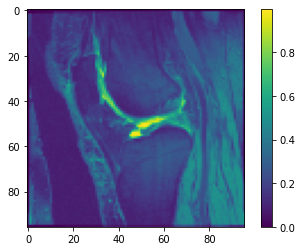

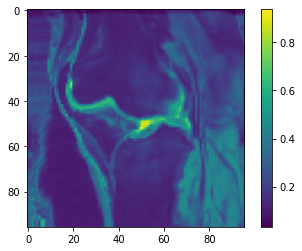

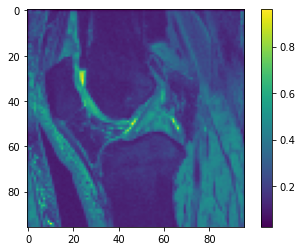

In [85]:
N -=1
plt.imshow(moving_image[N, 0, 16].cpu())
plt.colorbar()
plt.show()
plt.imshow(net.warped_fixed_image[N, 0, 16].detach().cpu())
plt.colorbar()
plt.show()
plt.imshow(fixed_image[N, 0, 16].cpu())
plt.colorbar()

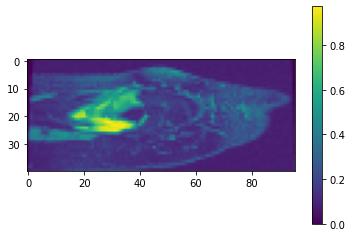

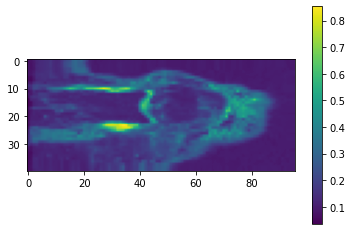

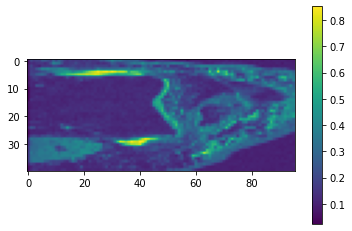

In [86]:
plt.imshow(moving_image[N, 0, :, :, 32].cpu())
plt.colorbar()
plt.show()
plt.imshow(net.warped_fixed_image[N, 0, :, :, 32].detach().cpu())
plt.colorbar()
plt.show()
plt.imshow(fixed_image[N, 0, :, :, 32].cpu())
plt.colorbar()

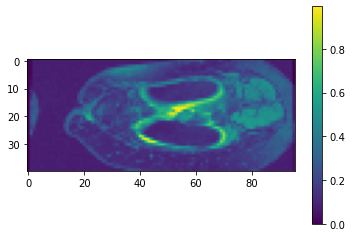

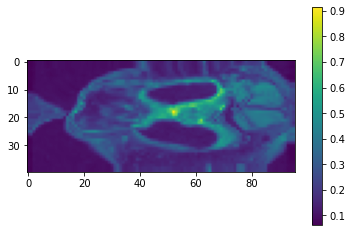

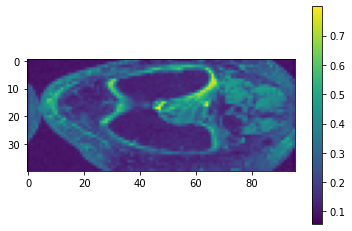

In [87]:
y=48
plt.imshow(moving_image[N, 0, :, y, :].cpu())
plt.colorbar()
plt.show()
plt.imshow(net.warped_fixed_image[N, 0, :, y, :].detach().cpu())
plt.colorbar()
plt.show()
plt.imshow(fixed_image[N, 0, :, y, :].cpu())
plt.colorbar()

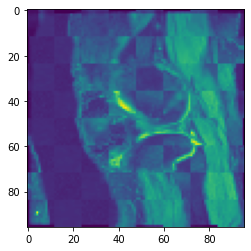

In [88]:

plt.imshow(mermaid.visualize_registration_results.checkerboard_2d(
    net.warped_fixed_image[N, 0, 8].detach().cpu(),
    moving_image[N, 0, 8].cpu()))

<function matplotlib.pyplot.scatter(x, y, s=None, c=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, verts=<deprecated parameter>, edgecolors=None, *, plotnonfinite=False, data=None, **kwargs)>

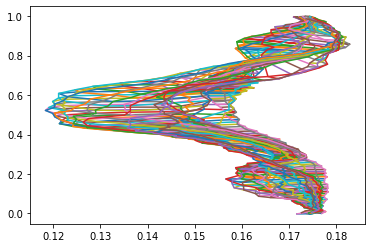

In [173]:
def grid(A, B):
    #plt.axes().set_aspect("equal")
    plt.plot(A, B)
    plt.plot(A.transpose(0, 1), B.transpose(0, 1))
    
def grd(d):
    grid(d[1], d[2])
    
grd(net.phi1[N, :, ::2, 16].detach().cpu())
plt.scatter

In [68]:
def get_phi(a, b):
    net(a[:BATCH_SIZE], b[:BATCH_SIZE])
    return net.phi1.detach().cpu()

In [69]:
phi2 = get_phi(fixed_image, moving_image)
phi1 = get_phi(moving_image, fixed_image)


/playpen-raid1/tgreer/anaconda3/envs/mermaid4/lib/python3.7/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


0.002696722513064742 0.015304483473300934 0.23566001653671265
0.0028089655097573996 0.015304483473300934 0.23227573931217194


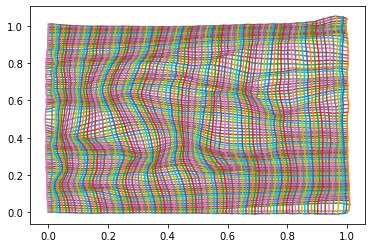

In [70]:

grd(phi2[N, :, 8, :, :])

In [71]:
ident_hope = py_utils.compute_warped_image_multiNC(phi2 - net.identityMap.cpu(), phi1, net.spacing, 1) + phi1.cpu()

/playpen-raid1/tgreer/anaconda3/envs/mermaid4/lib/python3.7/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


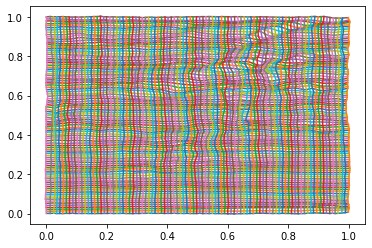

In [56]:
grd(ident_hope[N, :, 8, :, :])

In [34]:
del net

In [13]:
#torch.save(net.state_dict(), "knee_aligner_chonk6")

In [27]:
net.load_state_dict(torch.load("knee_aligner_chonk6"))
#optimizer.load_state_dict(torch.load("knee_aligner_optimizer6"))

<All keys matched successfully>

In [11]:
torch.cuda.empty_cache()

In [12]:
#torch.save(optimizer.state_dict(), "knee_aligner_optimizer6")

In [6]:
optimizer.state_dict()

NameError: name 'optimizer' is not defined

In [37]:
import pickle

In [38]:
with open("/playpen/tgreer/knees4" , "wb") as mk:
    pickle.dump(brains, mk)

In [13]:
with open("/playpen/tgreer/mediumknees3" , "wb") as mk:
    pickle.dump(medbrains, mk)

In [29]:
import pickle

In [38]:
net.adjust_batch_size(BATCH_SIZE//8)
net.cuda()

In [123]:
def make_test_batch():
    index = [random.randint(0, 240 - 1) for _ in range(BATCH_SIZE // 8)]
    image = torch.cat([medbrains[index[_]] for _ in range(BATCH_SIZE // 8)])
    image = image.reshape(BATCH_SIZE // 8, 1, 40, 96, 96)
    image = image.cuda()
    print(image.shape)
    cartilage_batch = torch.cat([torch.tensor(cartilage[index[_]])[None, :, :, :] for _ in range(BATCH_SIZE // 8)])
    #cartilage_batch = cartilage_batch[:, None, :]
    print(cartilage_batch.shape)
    cartilage_batch = cartilage_batch.cuda()
    return image, cartilage_batch

fixed_image, fixed_cartilage = make_test_batch()
moving_image, moving_cartilage = make_test_batch()

torch.Size([4, 1, 40, 96, 96])


/playpen-raid1/tgreer/anaconda3/envs/mermaid4/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


torch.Size([4, 1, 160, 384, 384])
torch.Size([4, 1, 40, 96, 96])
torch.Size([4, 1, 160, 384, 384])


/playpen-raid1/tgreer/anaconda3/envs/mermaid4/lib/python3.7/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


0.0031846403144299984 0.015667472034692764 0.2104710042476654


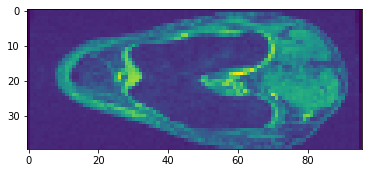

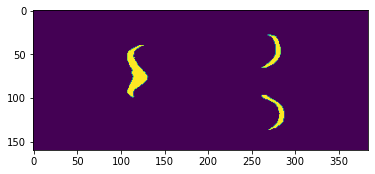

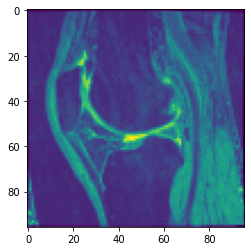

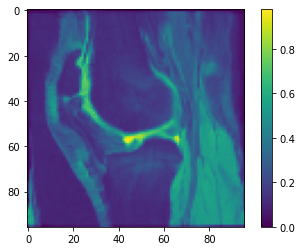

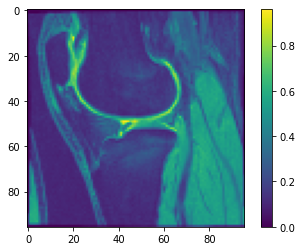

In [124]:
net(moving_image, fixed_image)

N =1
S =46
plt.imshow(moving_image[N, 0, :, S].cpu())
plt.show()
plt.imshow(moving_cartilage[N, 0, :, S * 4].cpu())
plt.show()

plt.imshow(moving_image[N, 0, 16].detach().cpu())
plt.show()
plt.imshow(net.warped_fixed_image[N, 0, 16].detach().cpu())
plt.colorbar()
plt.show()
plt.imshow(fixed_image[N, 0, 16].cpu())
plt.colorbar()



In [125]:
fat_phi = torch.nn.Upsample(size=moving_cartilage.size()[2:], mode="trilinear")(net.phi1)
sz = np.array(fat_phi.size())
spacing = 1./(sz[2::]-1) 
warped_moving_cartilage = py_utils.compute_warped_image_multiNC(moving_cartilage.float(), fat_phi, spacing, 1)

/playpen-raid1/tgreer/anaconda3/envs/mermaid4/lib/python3.7/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [126]:
import pickle

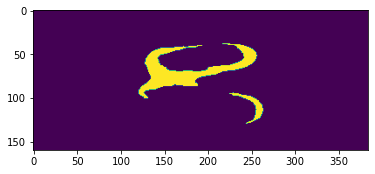

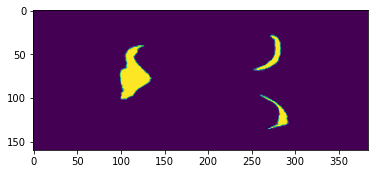

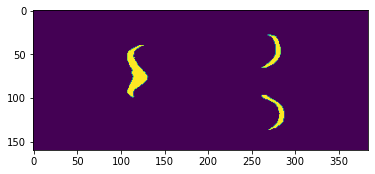

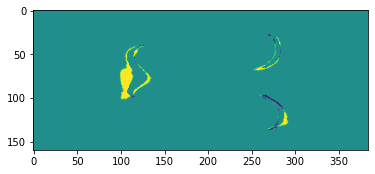

In [127]:
N =2
plt.imshow(moving_cartilage[N, 0, :, S * 4].cpu())
plt.show() 
plt.imshow(warped_moving_cartilage[N, 0, :, S * 4].detach().cpu())
plt.show()

plt.imshow(fixed_cartilage[N, 0, :, S * 4].cpu())
plt.show()

plt.imshow(warped_moving_cartilage[N, 0, :, S * 4].detach().cpu() - fixed_cartilage[N, 0, :, S * 4].cpu())
plt.show()


In [131]:
wmb = warped_moving_cartilage > .5
fb = fixed_cartilage > .5

In [134]:
intersection = wmb * fb


In [136]:
2 * torch.sum(intersection).float() / (torch.sum(wmb) + torch.sum(fb))

tensor(0.6648, device='cuda:0')

In [140]:
a = net.phi1[:, :, 1:, 1:, 1:] - net.phi1[:, :, :-1, 1:, 1:]
b = net.phi1[:, :, 1:, 1:, 1:] - net.phi1[:, :, 1:, :-1, 1:]
c = net.phi1[:, :, 1:, 1:, 1:] - net.phi1[:, :, 1:, 1:, :-1]

In [141]:
a.shape

torch.Size([4, 3, 39, 95, 95])

In [146]:
dV = torch.sum(torch.cross(a, b, 1) * c, axis=1, keepdims=True)

In [168]:
torch.sum(dV[3] < 0) / 4

tensor(687, device='cuda:0')

In [153]:
dV.shape

torch.Size([4, 1, 39, 95, 95])

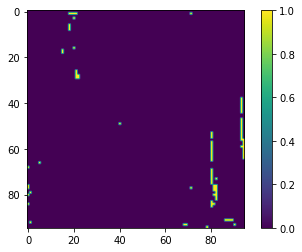

In [170]:
plt.imshow(dV[3, 0, 15].detach().cpu() < 0)
plt.colorbar()

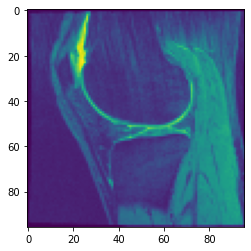

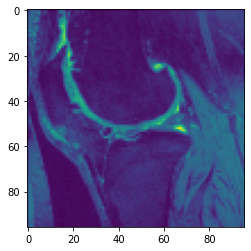

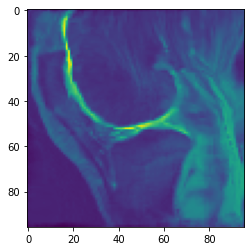

In [176]:
plt.imshow(moving_image[3, 0, 15].detach().cpu())
plt.show()
plt.imshow(fixed_image[3, 0, 15].detach().cpu())
plt.show()
plt.imshow(net.warped_moving_image[3, 0, 15].detach().cpu())

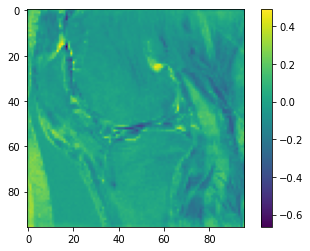

In [179]:
plt.imshow((fixed_image[3, 0, 15] - net.warped_moving_image[3, 0, 15]).detach().cpu())
plt.colorbar()